## <font color =  'skyblue'> IMPORTING LIBRARIES</font>

In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import spacy
import nltk
import re
import torch
import gensim
import tensorflow as tf
import keras
from sklearn.tree import DecisionTreeClassifier




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## <font color = 'skyblue'> PREPARING THE DATASET</font>

In [22]:
#load the dataset
train = pd.read_csv('/content/drive/MyDrive/PRML_MAJOR/jigsaw-toxic-comment-classification-challenge/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/PRML_MAJOR/jigsaw-toxic-comment-classification-challenge/test.csv')
test_labels = pd.read_csv('/content/drive/MyDrive/PRML_MAJOR/jigsaw-toxic-comment-classification-challenge/test_labels.csv')
# join test_data and test_labels
test = pd.merge(test_data, test_labels, on='id')
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [23]:
#drop id
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)
train

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [24]:
test

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1
153160,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1
153161,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1
153162,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1


<font color = 'pink'>PRECENTAGE OF ROWS NOT HAVING ANY LABELLING

In [25]:
# printing the percentage of -1 in target column
print('Percentage of -1 in target column in train data: ', (train['toxic'] == -1).sum()/len(train))
print('Percentage of -1 in target column in test data: ', (test['toxic'] == -1).sum()/len(train))

Percentage of -1 in target column in train data:  0.0
Percentage of -1 in target column in test data:  0.5589110803341459


In [26]:
# making a target column in both train and test dataset and assigning value as max of columns toxic,svere_toxic,obscene,threat,insult,identity_hate
train['target'] = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
test['target'] = test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [27]:
test

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target
0,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1,-1
1,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1,-1
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1,-1
3,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1,-1
4,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
153159,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1,-1
153160,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1,-1
153161,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1,-1
153162,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1,-1


In [28]:
#remove the rows having corresponding target value as -1
train = train[train['target'] != -1]
test = test[test['target'] != -1]
test

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target
5,Thank you for understanding. I think very high...,0,0,0,0,0,0,0
7,:Dear god this site is horrible.,0,0,0,0,0,0,0
11,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,0
13,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,0
14,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153150,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0,0
153151,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0,0
153154,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0,0
153155,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0,1


# <font color = 'skyblue'> PLOTTING THE DISTRIBUTION REGARDING EACH COLUMN

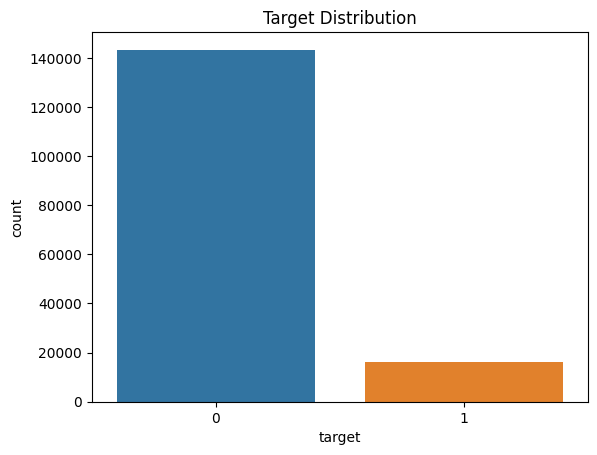

In [29]:
#plotting the no of comments in target column as hue
sns.countplot(x='target', data=train)
plt.title('Target Distribution')
plt.show()

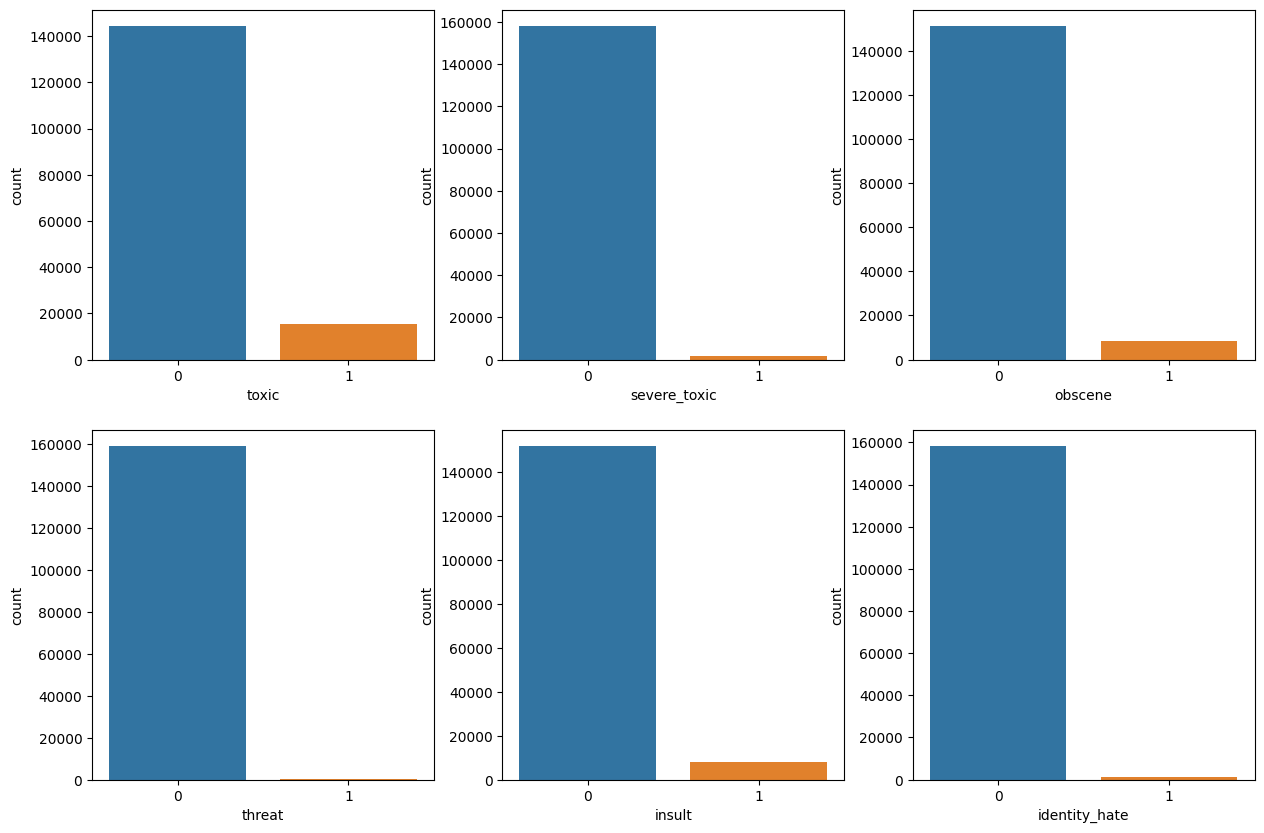

In [30]:
# PLOTTING THE COUNT OF ALL COLUMNS HAVING 1 IN THE SAME ORDER AND IN SAME PLOT HAVING DIFFRENT COLUMNS
fig, ax = plt.subplots(2,3, figsize=(15,10))
sns.countplot(x='toxic', data=train, ax=ax[0,0])
sns.countplot(x='severe_toxic', data=train, ax=ax[0,1])
sns.countplot(x='obscene', data=train, ax=ax[0,2])
sns.countplot(x='threat', data=train, ax=ax[1,0])
sns.countplot(x='insult', data=train, ax=ax[1,1])
sns.countplot(x='identity_hate', data=train, ax=ax[1,2])
plt.show()


In [31]:
# making a new column named as Multiple_tags and value as sum of values of all columns other than target
train['Multiple_tags'] = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
test['Multiple_tags'] = test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target,Multiple_tags
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,0


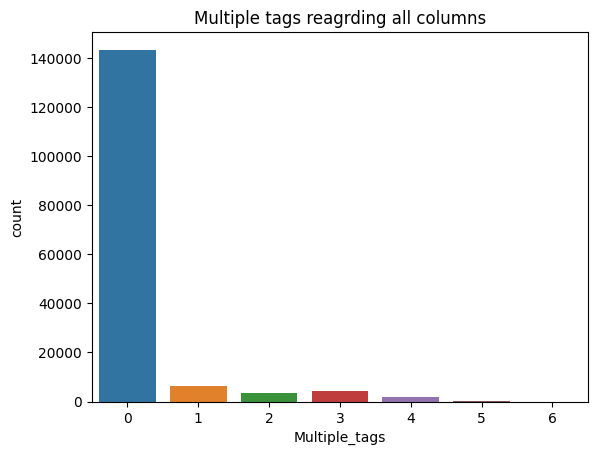

In [32]:
# PLOTTING THE MULTIPLE TAGS ALL REGARDING ROWS
sns.countplot(x='Multiple_tags', data=train)
plt.title('Multiple tags reagrding all columns')
plt.show()

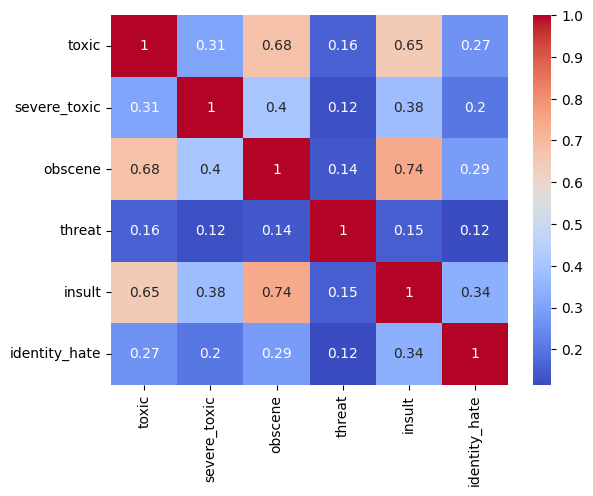

In [33]:
# plotting the correlation between the toxic,severe_toxic,obscene,threat,insult,identity_hate columns
sns.heatmap(train.iloc[:,1:7].corr(), annot=True, cmap='coolwarm')
plt.show()

CHECKING FOR THE COMMENTS CORRESPONDING ONE IN EACH COLUMN

In [34]:
# PRINTNG THE COMMENT ONE FOR EACH COLUMN HAVING 1
print('TOXIC COMMENT : ',train[train['toxic'] == 1]['comment_text'].values[0])
print('SEVERE TOXIC COMMENT : ',train[train['severe_toxic'] == 1]['comment_text'].values[0])
print('OBSCENE COMMENT : ',train[train['obscene'] == 1]['comment_text'].values[0])
print('THREAT COMMENT : ',train[train['threat'] == 1]['comment_text'].values[0])
print('INSULT COMMENT : ',train[train['insult'] == 1]['comment_text'].values[0])
print('IDENTITY HATE COMMENT : ',train[train['identity_hate'] == 1]['comment_text'].values[0])


TOXIC COMMENT :  COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
SEVERE TOXIC COMMENT :  COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
OBSCENE COMMENT :  COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
THREAT COMMENT :  Hi! I am back again!
Last warning!
Stop undoing my edits or die!
INSULT COMMENT :  COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
IDENTITY HATE COMMENT :  You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of 

In [35]:
# DROPPING THE TARGET, MULTIPLE_TAGS COLUMNS FROM THE TRAIN AND TEST DATASET
train.drop([ 'Multiple_tags'], axis=1, inplace=True)
test.drop([ 'Multiple_tags'], axis=1, inplace=True)

# <font color = 'skyblue'>WORD CLOUDS CORRSPONDING TO EACH COLUMN

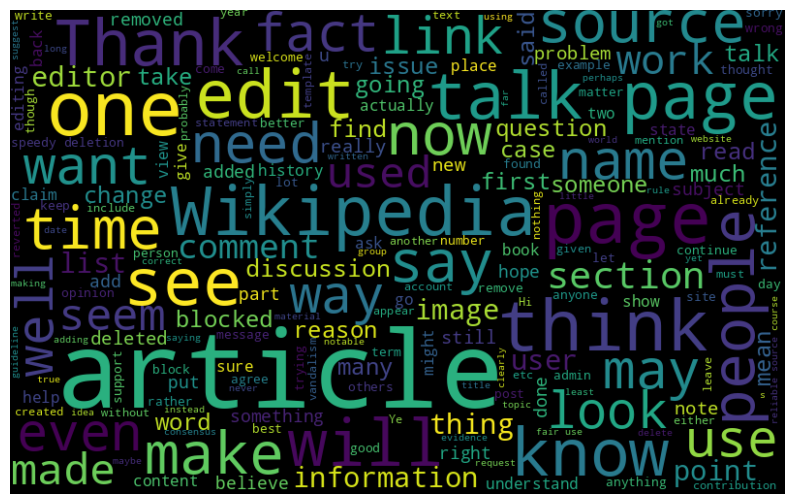

In [36]:
# PLOTTING THE WORD CLOUD FOR THE COMMENT_TEXT COLUMN IN TRAIN SET FOR CLEAN COMMNETS HAVING 0 IN ALL COLUMNS
from wordcloud import WordCloud
clean_comments = train[train['target'] == 0]['comment_text'].values
clean_comments = ' '.join(clean_comments)
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(clean_comments)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

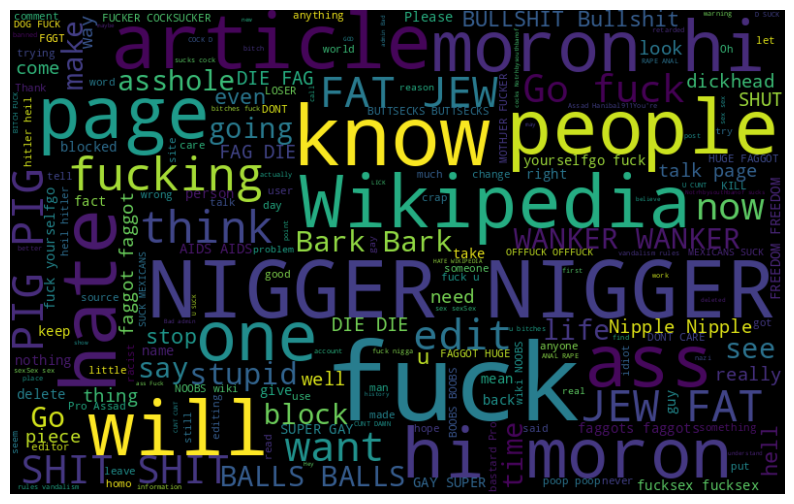

In [37]:
# PLOTTING THE tOXIC WORD CLOUD FOR THE COMMENT_TEXT COLUMN IN TRAIN SET FOR tOXIC COMMNETS HAVING 1 IN TOXIC COLUMN
toxic_comments = train[train['toxic'] == 1]['comment_text'].values
toxic_comments = ' '.join(toxic_comments)
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(toxic_comments)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

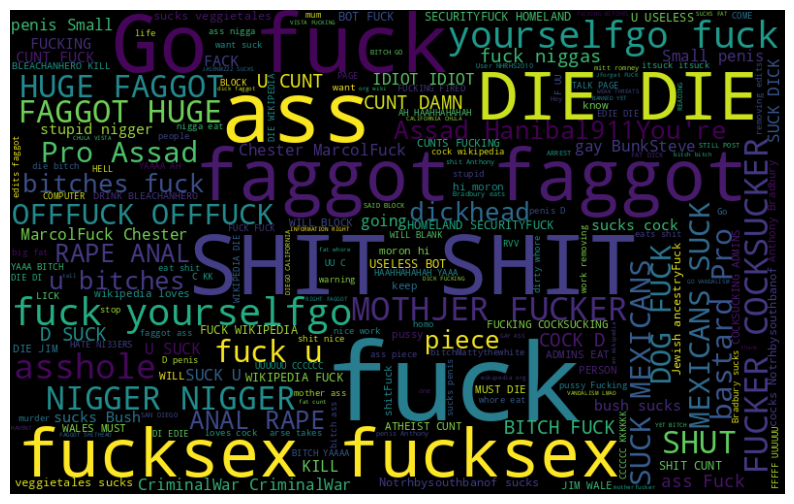

In [38]:
# PLOTTING THE tOXIC WORD CLOUD FOR THE COMMENT_TEXT COLUMN IN TRAIN SET FOR tOXIC COMMNETS HAVING 1 IN SEVERE_TOXIC COLUMN
toxic_comments = train[train['severe_toxic'] == 1]['comment_text'].values
toxic_comments = ' '.join(toxic_comments)
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(toxic_comments)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

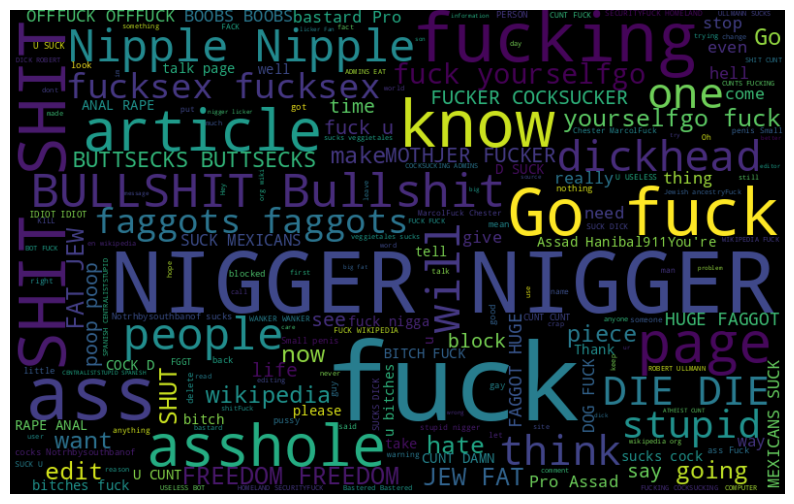

In [39]:
# PLOTTING THE tOXIC WORD CLOUD FOR THE COMMENT_TEXT COLUMN IN TRAIN SET FOR tOXIC COMMNETS HAVING 1 IN OBSCENE COLUMN
toxic_comments = train[train['obscene'] == 1]['comment_text'].values
toxic_comments = ' '.join(toxic_comments)
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(toxic_comments)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

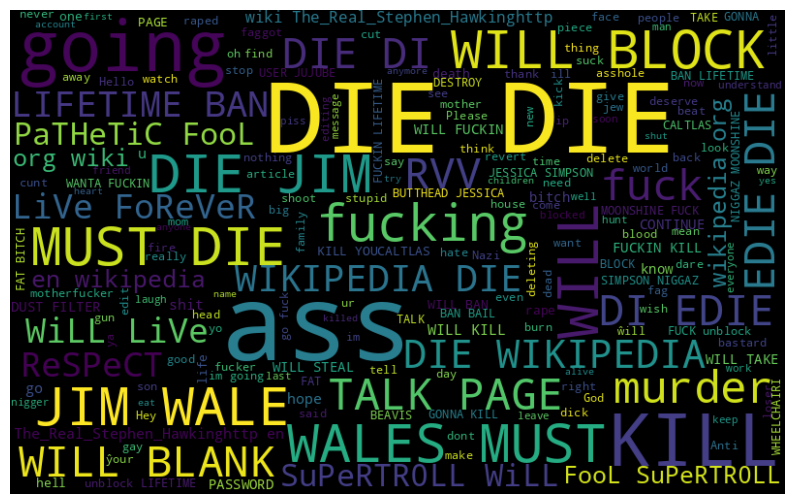

In [40]:
# PLOTTING THE tOXIC WORD CLOUD FOR THE COMMENT_TEXT COLUMN IN TRAIN SET FOR tOXIC COMMNETS HAVING 1 IN THREAT COLUMN
toxic_comments = train[train['threat'] == 1]['comment_text'].values
toxic_comments = ' '.join(toxic_comments)
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(toxic_comments)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

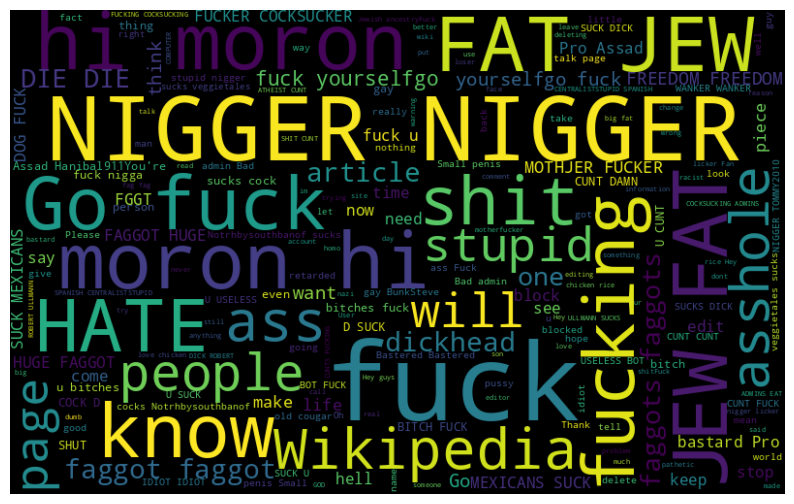

In [41]:
# PLOTTING THE tOXIC WORD CLOUD FOR THE COMMENT_TEXT COLUMN IN TRAIN SET FOR tOXIC COMMNETS HAVING 1 IN INSULT COLUMN
toxic_comments = train[train['insult'] == 1]['comment_text'].values
toxic_comments = ' '.join(toxic_comments)
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(toxic_comments)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

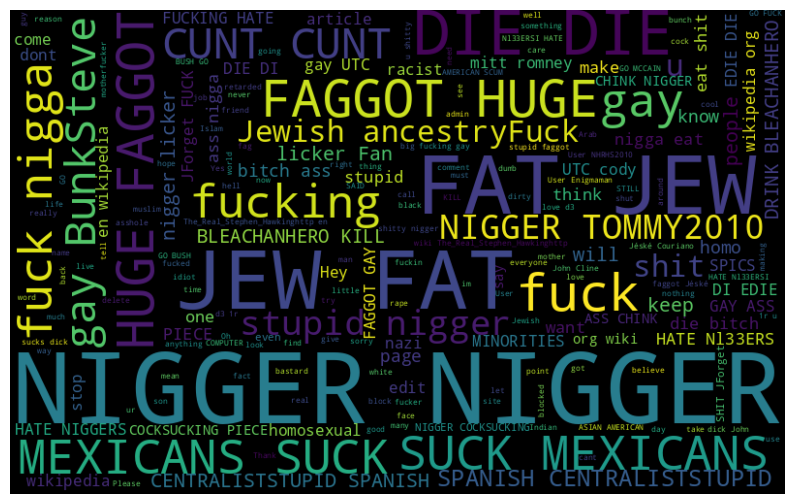

In [42]:
# PLOTTING THE tOXIC WORD CLOUD FOR THE COMMENT_TEXT COLUMN IN TRAIN SET FOR tOXIC COMMNETS HAVING 1 IN IDENTITY HATE COLUMN
toxic_comments = train[train['identity_hate'] == 1]['comment_text'].values
toxic_comments = ' '.join(toxic_comments)
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(toxic_comments)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# <font color = 'skyblue'>ANALYZING SOME FACTORS IN THE DATASET

In [43]:
# MERGING TRAIN AND TEST TO CHECK FOR SOME ANALYZING FACTORS IN THE DATASET
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [44]:
import string
from spacy.lang.en.stop_words import STOP_WORDS as eng_stopwords
#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [45]:
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [46]:
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

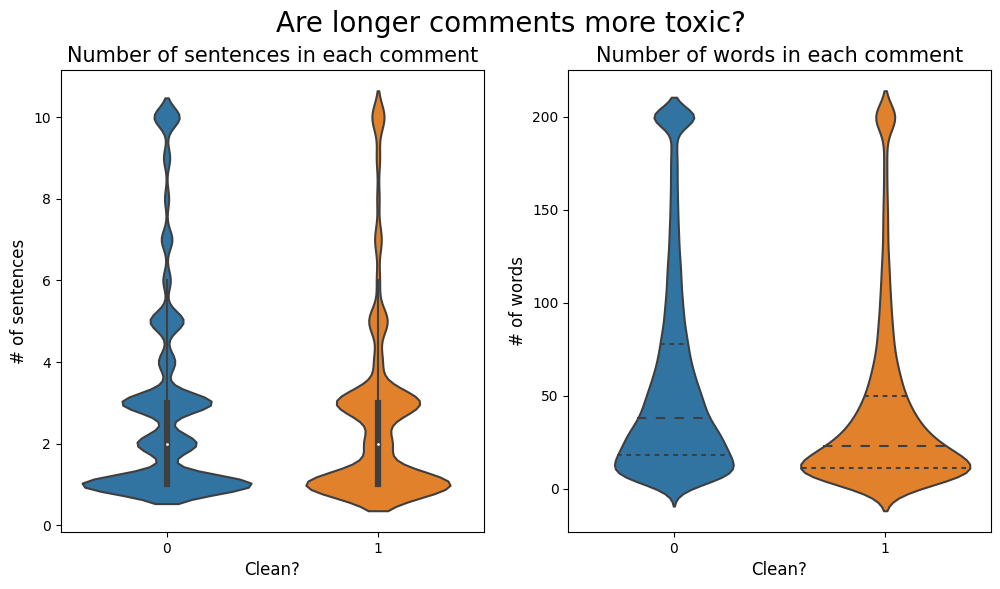

In [47]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='target', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='target', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

Long sentences or more words do not seem to be a significant indicator of toxicity.

Chart desc: Violin plot is an alternative to the traditional box plot. The inner markings show the percentiles while the width of the "violin" shows the volume of comments at that level/instance.

In [48]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='target')
#spammers - comments with less than 40% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]

Text(0.5, 0, 'Percent unique words')

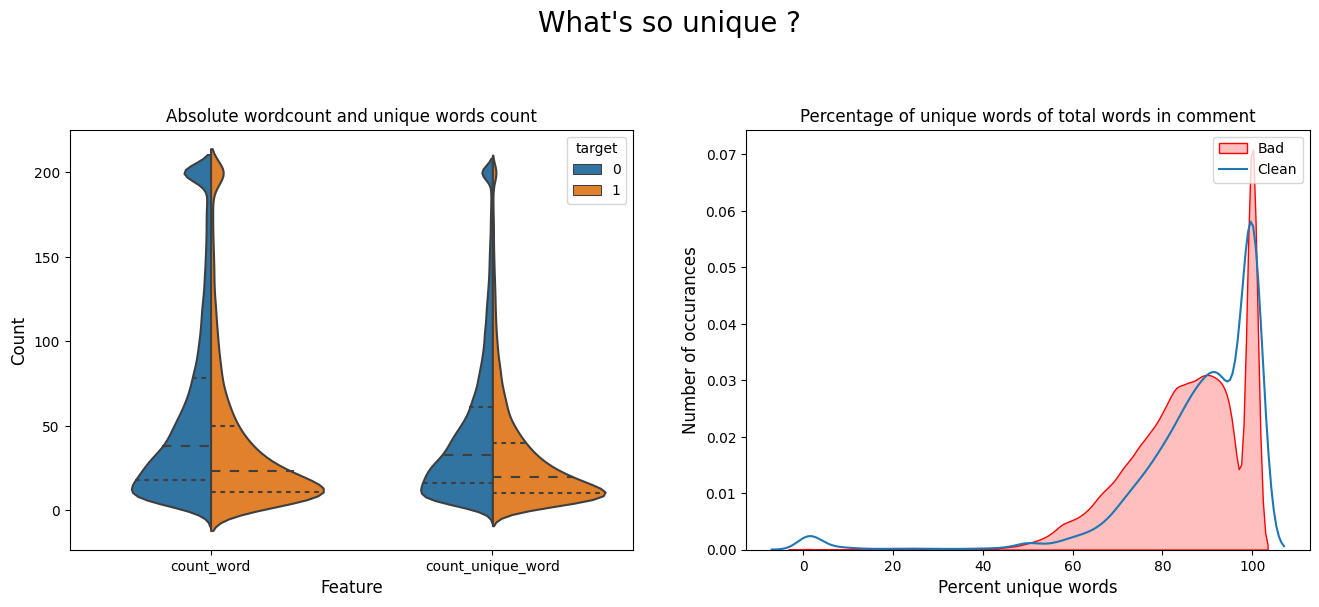

In [49]:
import matplotlib.gridspec as gridspec 
plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='target', data=temp_df,split=True,inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.target == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.target == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)


Word count VS unique word count:
There are noticeable shifts in the mean of both word count and unique word count across clean and toxic comments.

Chart desc: The first chart is a split violin chart. It is a variation of the traditional box chart/violin chart which allows us to split the violin in the middle based on a categorical variable.
Unique word count percent:
There is a bulge near the 0-10% mark which indicates a large number of toxic comments which contain very little variety of words.

Chart desc: The second chart is an overlay of two kernel density estimation plots of percentage of unique words out of all the words in the comment, done for both clean and toxic comments
Even though the number of clean comments dominates the dataset(~90%), there are only 75 clean comments that are spam, which makes it a powerful indicator of a toxic comment.

# <font color = 'skyblue'>PREPROCESSING OF THE DATA BEFORE APPLYING WORD TO VECTORS CONVERTING TECHNIQUES

# <font color = 'skyblue' >Cleaning Data with Regex

In [50]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

# run the function on the comment_text column of the train and test data
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))
test['comment_text'] = test['comment_text'].map(lambda com : clean_text(com))

# <font color = 'skyblue'>CONVERTING THE COMMENT COLUMN TO LOWERCASE

In [51]:
train['comment_text'] = train['comment_text'].map(lambda com : com.lower())
test['comment_text'] = test['comment_text'].map(lambda com : com.lower())

# <font color = 'skyblue'>REPLACING ABBRIVATED WORDS FROM DATA

In [52]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}
# replace the words in the dictionary with their values
def replace_words(text):
    text = text.split()
    new_text = []
    for word in text:
        if word in APPO:
            new_text.append(APPO[word])
        else:
            new_text.append(word)
    new_text = " ".join(new_text)
    return new_text


In [53]:
train 

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target
0,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,d aww he matches this background colour i am s...,0,0,0,0,0,0,0
2,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,0
3,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,and for the second time of asking when your vi...,0,0,0,0,0,0,0
159567,you should be ashamed of yourself that is a ho...,0,0,0,0,0,0,0
159568,spitzer umm theres no actual article for prost...,0,0,0,0,0,0,0
159569,and it looks like it was actually you who put ...,0,0,0,0,0,0,0


Le

In [54]:
# tokenizing and lemmetizing the comment_text column of the train and test data using nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
train['comment_text'] = train['comment_text'].map(lambda com : [lemmatizer.lemmatize(word) for word in word_tokenize(com)])
test['comment_text'] = test['comment_text'].map(lambda com : [lemmatizer.lemmatize(word) for word in word_tokenize(com)])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# <font color = 'skyblue'>REMOVING STOP WORDS FROM DATA

In [55]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [56]:
# removing stopwords from the comment_text column of the train and test data using nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
train['comment_text'] = train['comment_text'].map(lambda com : [word for word in com if word not in stop_words])
test['comment_text'] = test['comment_text'].map(lambda com : [word for word in com if word not in stop_words])

In [57]:
train

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target
0,"[explanation, edits, made, username, hardcore,...",0,0,0,0,0,0,0
1,"[aww, match, background, colour, seemingly, st...",0,0,0,0,0,0,0
2,"[hey, man, really, trying, edit, war, guy, con...",0,0,0,0,0,0,0
3,"[make, real, suggestion, improvement, wondered...",0,0,0,0,0,0,0
4,"[sir, hero, chance, remember, page]",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,"[second, time, asking, view, completely, contr...",0,0,0,0,0,0,0
159567,"[ashamed, horrible, thing, put, talk, page, 12...",0,0,0,0,0,0,0
159568,"[spitzer, umm, actual, article, prostitution, ...",0,0,0,0,0,0,0
159569,"[look, like, wa, actually, put, speedy, first,...",0,0,0,0,0,0,0


In [58]:
train.to_csv('train_cleaned.csv', header=True)
test.to_csv('test_cleaned.csv',  header=True)

#<font color = 'skyblue'>APPYING FREQUENCY OR COUNT BASED VECTORIZER

# <font color = 'skyblue'>APPLYING TFIDF VECTORIZER ON DATA

TFIDF WITH NGRAMS = 1

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
train['comment_text'] = train['comment_text'].apply(lambda x: ' '.join(x))
test['comment_text'] = test['comment_text'].apply(lambda x: ' '.join(x))
# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer()
# Fit and transform the text data
train_tfidf = tfidf.fit_transform(train['comment_text'])
test_tfidf = tfidf.transform(test['comment_text'])


In [60]:
import pickle
pickle_out=open("tfidf_vectorizer.pkl","wb")
pickle.dump(tfidf,pickle_out)
pickle_out.close()

In [61]:
print(train['comment_text'].shape)

(159571,)


In [62]:
print(type(train['comment_text']))

<class 'pandas.core.series.Series'>


TFIDF WITH NGRAMS = 2

In [63]:
tfidf2 = TfidfVectorizer(ngram_range=(1,3))
# Fit and transform the text data
train_tfidf2 = pd.DataFrame()
test_tfidf2 = pd.DataFrame()

train_tfidf2 = tfidf2.fit_transform(train['comment_text'])
test_tfidf2 = tfidf2.transform(test['comment_text'])


ASSUMPTION : As we have analysed earlier also the words in the comments are independent of each other their meaning individually and combining with other words doesn't make any impact on its meaning. So, probably bigram will be performing similar as unigram in Classification

# <font color = 'skyblue'> TRAINING MULTINOMIAL NAIVE BAYES MODEL

In [64]:
train_tfidf

<159571x180103 sparse matrix of type '<class 'numpy.float64'>'
	with 4471322 stored elements in Compressed Sparse Row format>

In [65]:
accuracies_nb = []
acuuracies_log = []
accuracies_nb2 = []
acuuracies_log2 = []

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     57888
           1       0.87      0.21      0.34      6090

    accuracy                           0.92     63978
   macro avg       0.90      0.60      0.65     63978
weighted avg       0.92      0.92      0.90     63978

0.9217074619400419


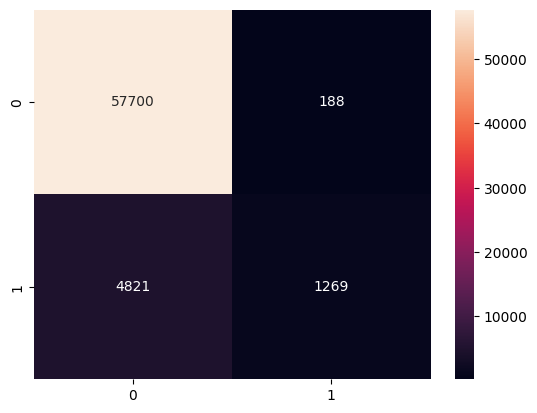

In [66]:
# training the multinomial naive bayes model on the train data
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
clf_nb_toxic = MultinomialNB()
clf_nb_toxic.fit(train_tfidf, train['toxic'])

# predicting the values for the test data
y_pred = clf_nb_toxic.predict(test_tfidf)
print(classification_report(test['toxic'], y_pred))
accuracies_nb.append(accuracy_score(test['toxic'],y_pred))
# printing accuracy
print(accuracies_nb[-1])
# plotting the confusion matrix
cm = confusion_matrix(test['toxic'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [67]:
import pickle
pickle_out=open("clf_nb_toxic.pkl","wb")
pickle.dump(clf_nb_toxic,pickle_out)
pickle_out.close()

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     57888
           1       0.97      0.07      0.13      6090

    accuracy                           0.91     63978
   macro avg       0.94      0.53      0.54     63978
weighted avg       0.92      0.91      0.87     63978

0.9110475475944856


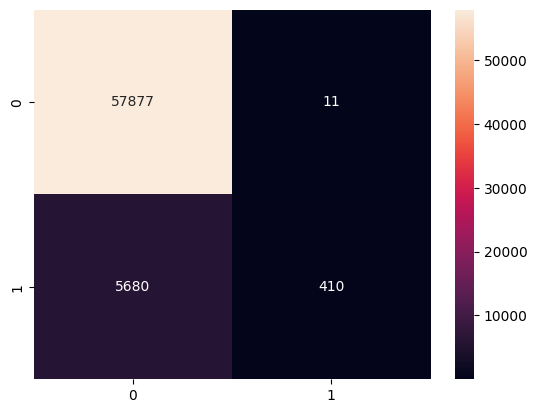

In [68]:
# training the multinomial naive bayes model on the train data
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
clf_nb_toxic2 = MultinomialNB()
clf_nb_toxic2.fit(train_tfidf2, train['toxic'])

# predicting the values for the test data
y_pred = clf_nb_toxic2.predict(test_tfidf2)
print(classification_report(test['toxic'], y_pred))
accuracies_nb2.append(accuracy_score(test['toxic'],y_pred))
# printing accuracy
print(accuracies_nb2[-1])
# plotting the confusion matrix
cm = confusion_matrix(test['toxic'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     63611
           1       0.00      0.00      0.00       367

    accuracy                           0.99     63978
   macro avg       0.50      0.50      0.50     63978
weighted avg       0.99      0.99      0.99     63978

0.9942636531307637


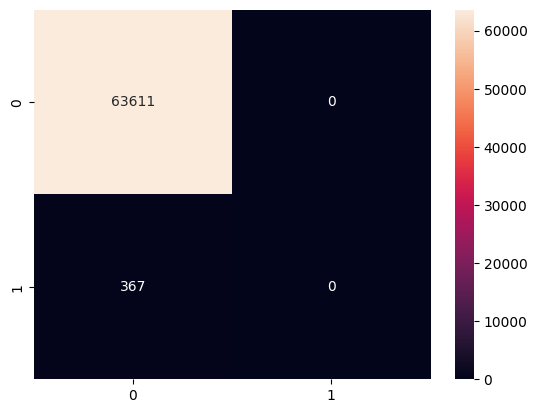

In [69]:
clf_nb_severe_toxic = MultinomialNB()
clf_nb_severe_toxic.fit(train_tfidf, train['severe_toxic'])

# predicting the values for the test data
y_pred = clf_nb_severe_toxic.predict(test_tfidf)
print(classification_report(test['severe_toxic'], y_pred))
# printing accuracy
accuracies_nb.append(accuracy_score(test['severe_toxic'],y_pred))
# printing accuracy
print(accuracies_nb[-1])
cm = confusion_matrix(test['severe_toxic'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     63611
           1       0.00      0.00      0.00       367

    accuracy                           0.99     63978
   macro avg       0.50      0.50      0.50     63978
weighted avg       0.99      0.99      0.99     63978

0.9942636531307637


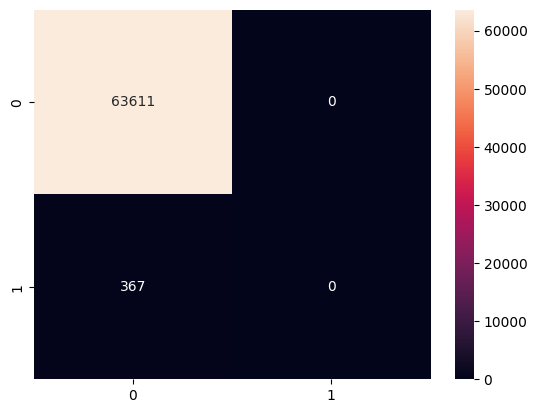

In [70]:
clf_nb_severe_toxic2= MultinomialNB()
clf_nb_severe_toxic2.fit(train_tfidf2, train['severe_toxic'])

# predicting the values for the test data
y_pred = clf_nb_severe_toxic2.predict(test_tfidf2)
print(classification_report(test['severe_toxic'], y_pred))
# printing accuracy
accuracies_nb2.append(accuracy_score(test['severe_toxic'],y_pred))
# printing accuracy
print(accuracies_nb2[-1])
cm = confusion_matrix(test['severe_toxic'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

Results : As we have seen also the accuracy and the results are not so much different for unigram and bigram, So our assumption is also true. So , we can just classify according to unigram itself.

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     60551
           1       0.82      0.05      0.09      3427

    accuracy                           0.95     63978
   macro avg       0.88      0.52      0.53     63978
weighted avg       0.94      0.95      0.93     63978

0.9485135515333396


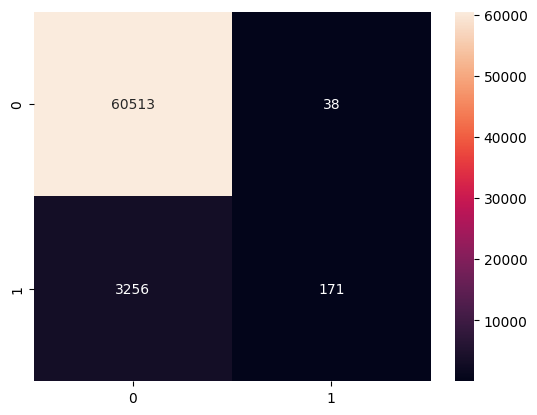

In [71]:
clf_nb_insult = MultinomialNB()
clf_nb_insult.fit(train_tfidf, train['insult'])

# predicting the values for the test data
y_pred = clf_nb_insult.predict(test_tfidf)
print(classification_report(test['insult'], y_pred))
accuracies_nb.append(accuracy_score(test['insult'],y_pred))
# printing accuracy
print(accuracies_nb[-1])
# plotting the confusion matrix
cm = confusion_matrix(test['insult'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     60287
           1       0.90      0.12      0.21      3691

    accuracy                           0.95     63978
   macro avg       0.93      0.56      0.59     63978
weighted avg       0.95      0.95      0.93     63978

0.9484197692956954


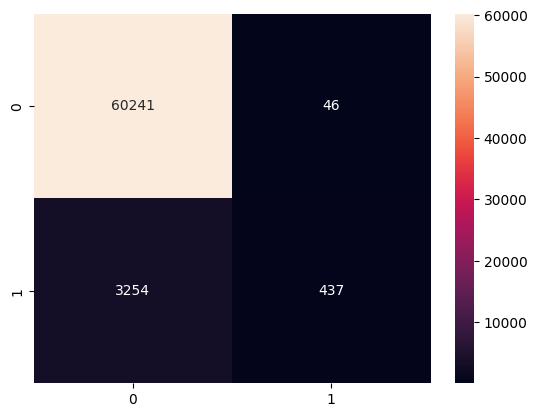

In [72]:
clf_nb_obscene = MultinomialNB()
clf_nb_obscene.fit(train_tfidf, train['obscene'])

# predicting the values for the test data
y_pred = clf_nb_obscene.predict(test_tfidf)
print(classification_report(test['obscene'], y_pred))
accuracies_nb.append(accuracy_score(test['obscene'],y_pred))
# printing accuracy
print(accuracies_nb[-1])
# plotting the confusion matrix
cm = confusion_matrix(test['obscene'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     63266
           1       0.00      0.00      0.00       712

    accuracy                           0.99     63978
   macro avg       0.49      0.50      0.50     63978
weighted avg       0.98      0.99      0.98     63978

0.9888711744662227


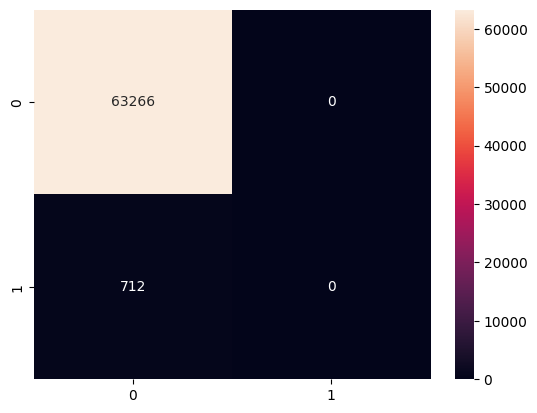

In [73]:
clf_nb_identity_hate = MultinomialNB()
clf_nb_identity_hate.fit(train_tfidf, train['identity_hate'])

# predicting the values for the test data
y_pred = clf_nb_identity_hate.predict(test_tfidf)
print(classification_report(test['identity_hate'], y_pred))
accuracies_nb.append(accuracy_score(test['identity_hate'],y_pred))
# printing accuracy
print(accuracies_nb[-1])
# plotting the confusion matrix
cm = confusion_matrix(test['identity_hate'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63767
           1       0.00      0.00      0.00       211

    accuracy                           1.00     63978
   macro avg       0.50      0.50      0.50     63978
weighted avg       0.99      1.00      1.00     63978

0.9967019913095126


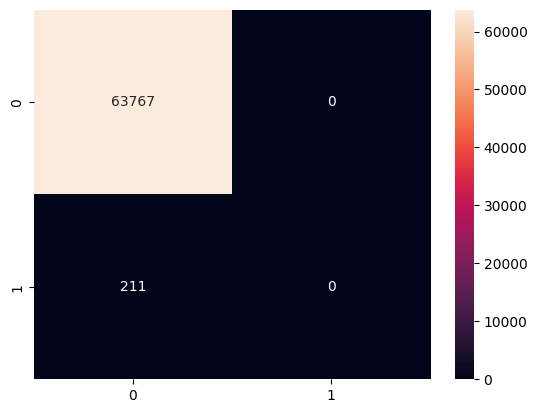

In [74]:
clf_nb_threat = MultinomialNB()
clf_nb_threat.fit(train_tfidf, train['threat'])

# predicting the values for the test data
y_pred = clf_nb_threat.predict(test_tfidf)
print(classification_report(test['threat'], y_pred))
accuracies_nb.append(accuracy_score(test['threat'],y_pred))
# printing accuracy
print(accuracies_nb[-1])
# plotting the confusion matrix
cm = confusion_matrix(test['threat'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

#<font color = 'skyblue'> TRAINING LOGISTIC REGRESSION ON THE DATA

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     57888
           1       0.66      0.70      0.68      6090

    accuracy                           0.94     63978
   macro avg       0.81      0.83      0.82     63978
weighted avg       0.94      0.94      0.94     63978

0.9369627059301635


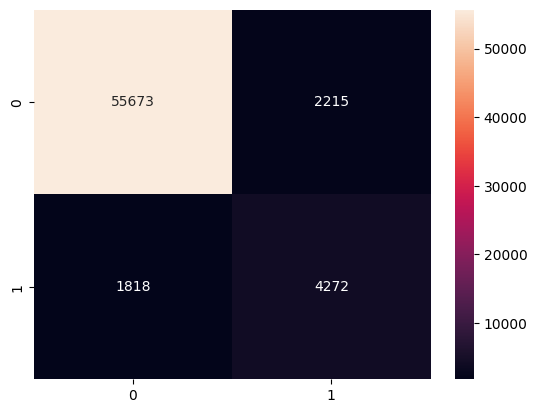

In [75]:
# training the logistic regression model on the train data
from sklearn.linear_model import LogisticRegression
clf_log_toxic = LogisticRegression()
clf_log_toxic.fit(train_tfidf, train['toxic'])

# predicting the values for the test data
y_pred = clf_log_toxic.predict(test_tfidf)
print(classification_report(test['toxic'], y_pred))
acuuracies_log.append(accuracy_score(test['toxic'], y_pred))
print(acuuracies_log[-1])
# plotting the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test['toxic'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [76]:
pickle_out=open("clf_log_toxic.pkl","wb")
pickle.dump(clf_log_toxic,pickle_out)
pickle_out.close()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63611
           1       0.39      0.32      0.35       367

    accuracy                           0.99     63978
   macro avg       0.69      0.66      0.67     63978
weighted avg       0.99      0.99      0.99     63978

0.9932320485166776


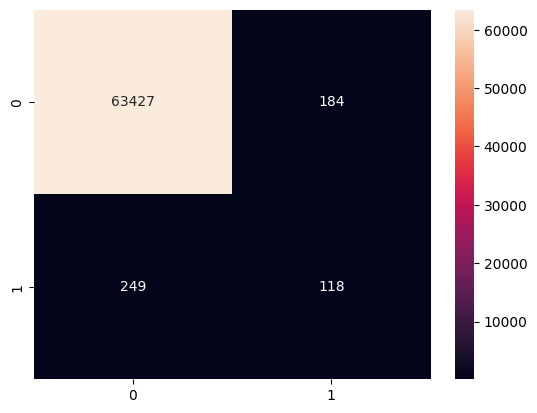

In [77]:
# training the logistic regression model on the train data
clf_log_severe_toxic = LogisticRegression()
clf_log_severe_toxic.fit(train_tfidf, train['severe_toxic'])

# predicting the values for the test data
y_pred = clf_log_severe_toxic.predict(test_tfidf)
print(classification_report(test['severe_toxic'], y_pred))
acuuracies_log.append(accuracy_score(test['severe_toxic'], y_pred))
print(acuuracies_log[-1])
# plotting the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test['severe_toxic'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [78]:
import pickle
pickle_out=open("sever_toxic.pkl","wb")
pickle.dump(clf_log_severe_toxic,pickle_out)
pickle_out.close()

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     60551
           1       0.73      0.53      0.61      3427

    accuracy                           0.96     63978
   macro avg       0.85      0.76      0.80     63978
weighted avg       0.96      0.96      0.96     63978

0.964143924474038


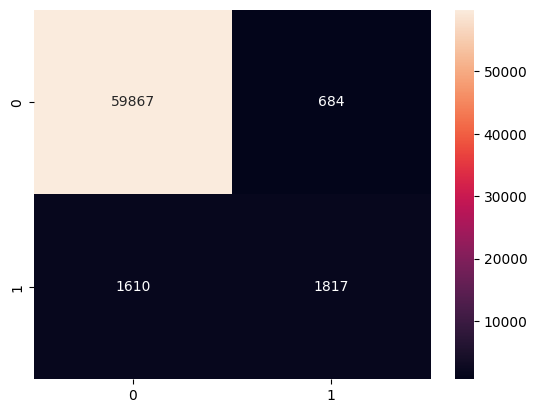

In [79]:
# training the logistic regression model on the train data
from sklearn.linear_model import LogisticRegression
clf_log_insult = LogisticRegression()
clf_log_insult.fit(train_tfidf, train['insult'])

# predicting the values for the test data
y_pred = clf_log_insult.predict(test_tfidf)
print(classification_report(test['insult'], y_pred))
acuuracies_log.append(accuracy_score(test['insult'], y_pred))
print(acuuracies_log[-1])
# plotting the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test['insult'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [80]:
pickle_out=open("insult.pkl","wb")
pickle.dump(clf_log_insult,pickle_out)
pickle_out.close()

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     60287
           1       0.76      0.62      0.68      3691

    accuracy                           0.97     63978
   macro avg       0.87      0.80      0.83     63978
weighted avg       0.96      0.97      0.96     63978

0.9665666322798462


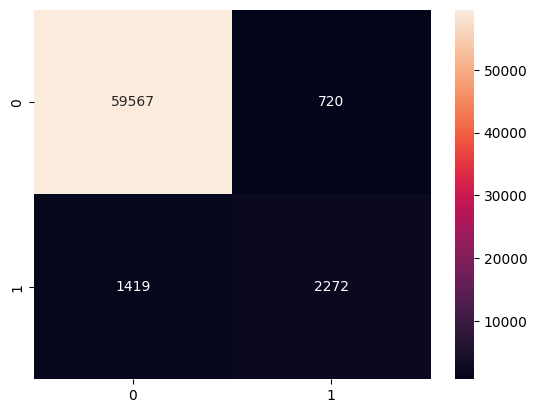

In [81]:
# training the logistic regression model on the train data
from sklearn.linear_model import LogisticRegression
clf_log_obscene = LogisticRegression()
clf_log_obscene.fit(train_tfidf, train['obscene'])

# predicting the values for the test data
y_pred = clf_log_obscene.predict(test_tfidf)
print(classification_report(test['obscene'], y_pred))
acuuracies_log.append(accuracy_score(test['obscene'], y_pred))
print(acuuracies_log[-1])
# plotting the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test['obscene'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [82]:
pickle_out=open("obscene.pkl","wb")
pickle.dump(clf_log_obscene,pickle_out)
pickle_out.close()

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     63266
           1       0.69      0.26      0.38       712

    accuracy                           0.99     63978
   macro avg       0.84      0.63      0.69     63978
weighted avg       0.99      0.99      0.99     63978

0.9904342117602926


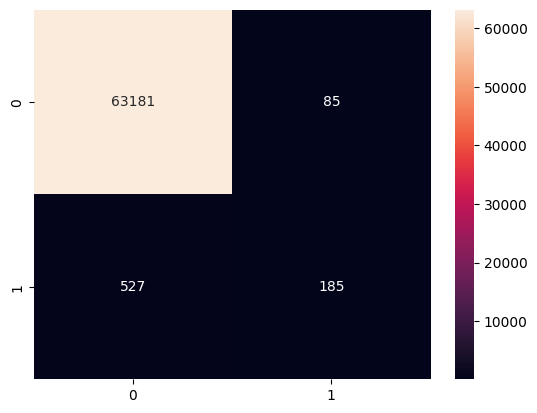

In [83]:
# training the logistic regression model on the train data
from sklearn.linear_model import LogisticRegression
clf_log_identity_hate = LogisticRegression()
clf_log_identity_hate.fit(train_tfidf, train['identity_hate'])

# predicting the values for the test data
y_pred = clf_log_identity_hate.predict(test_tfidf)
print(classification_report(test['identity_hate'], y_pred))
acuuracies_log.append(accuracy_score(test['identity_hate'], y_pred))
print(acuuracies_log[-1])
# plotting the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test['identity_hate'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [84]:
pickle_out=open("identity_hate.pkl","wb")
pickle.dump(clf_log_identity_hate,pickle_out)
pickle_out.close()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63767
           1       0.51      0.20      0.29       211

    accuracy                           1.00     63978
   macro avg       0.75      0.60      0.64     63978
weighted avg       1.00      1.00      1.00     63978

0.9967176216824534


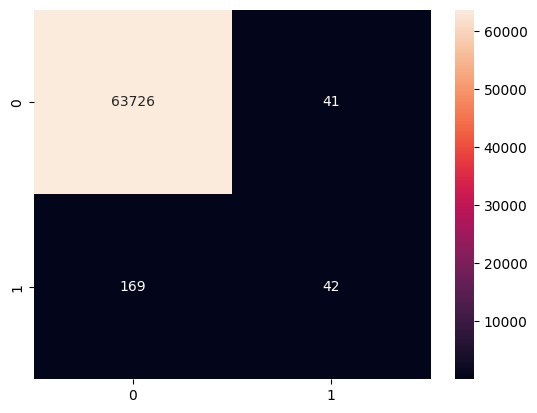

In [85]:
# training the logistic regression model on the train data
from sklearn.linear_model import LogisticRegression
clf_log_threat = LogisticRegression()
clf_log_threat.fit(train_tfidf, train['threat'])

# predicting the values for the test data
y_pred = clf_log_threat.predict(test_tfidf)
print(classification_report(test['threat'], y_pred))
acuuracies_log.append(accuracy_score(test['threat'], y_pred))
print(acuuracies_log[-1])
# plotting the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test['threat'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [86]:
pickle_out=open("threat.pkl","wb")
pickle.dump(clf_log_threat,pickle_out)
pickle_out.close()

In [87]:
print(accuracies_nb)
print(acuuracies_log)

[0.9217074619400419, 0.9942636531307637, 0.9485135515333396, 0.9484197692956954, 0.9888711744662227, 0.9967019913095126]
[0.9369627059301635, 0.9932320485166776, 0.964143924474038, 0.9665666322798462, 0.9904342117602926, 0.9967176216824534]


RESULT : SINCE WE KNOW THAT THE ACCURACY FOR TOXIC COLUMN IS COMAPRITIVELY LOW SO WILL BE DOING SOME EXPERIMENTS FOR TOXIC COLUMN CLASSIFACTION

# <font color = 'skyblue'>TRAINING FASTTEXT MODEL FOR TOXIC COLUMN TO CHECK IF IT CAN INCREASE ACCURACY

In [88]:
# PREPARING THE DATA FOR TRAINING FASTTEXT CLASSIFIER AND MAKE A NEW DATASET NAMELY TRAIN_FT
train_ft = train.copy()
# REPLACING 0 WITH NOT TOXIC AND 1 WITH TOXIC
train_ft['toxic'] = train_ft['toxic'].replace(0, '__label__not_toxic')
train_ft['toxic'] = train_ft['toxic'].replace(1, '__label__toxic')
train_ft['severe_toxic'] = train_ft['severe_toxic'].replace(0, '__label__not_severe_toxic')
train_ft['severe_toxic'] = train_ft['severe_toxic'].replace(1, '__label__severe_toxic')
train_ft['obscene'] = train_ft['obscene'].replace(0, '__label__not_obscene')
train_ft['obscene'] = train_ft['obscene'].replace(1, '__label__obscene')
train_ft['threat'] = train_ft['threat'].replace(0, '__label__not_threat')
train_ft['threat'] = train_ft['threat'].replace(1, '__label__threat')
train_ft['insult'] = train_ft['insult'].replace(0, '__label__not_insult')
train_ft['insult'] = train_ft['insult'].replace(1, '__label__insult')
train_ft['identity_hate'] = train_ft['identity_hate'].replace(0, '__label__not_identity_hate')
train_ft['identity_hate'] = train_ft['identity_hate'].replace(1, '__label__identity_hate')
train_ft['comment_text'] = train_ft['comment_text'].str.replace('\n', ' ')
train_ft['comment_text'] = train_ft['comment_text'].str.replace('\t', ' ')
train_ft['comment_text'] = train_ft['comment_text'].str.replace('\r', ' ')
train_ft['comment_text'] = train_ft['comment_text'].str.replace('"', ' ')
train_ft['comment_text'] = train_ft['comment_text'].str.replace("'", ' ')
train_ft['comment_text'] = train_ft['comment_text'].str.replace('  ', ' ')
train_ft['comment_text'] = train_ft['comment_text'].str.replace('   ', ' ')

# same for test data
test_ft = test.copy()
test_ft['toxic'] = test_ft['toxic'].replace(0, '__label__not_toxic')
test_ft['toxic'] = test_ft['toxic'].replace(1, '__label__toxic')
test_ft['severe_toxic'] = test_ft['severe_toxic'].replace(0, '__label__not_severe_toxic')
test_ft['severe_toxic'] = test_ft['severe_toxic'].replace(1, '__label__severe_toxic')
test_ft['obscene'] = test_ft['obscene'].replace(0, '__label__not_obscene')
test_ft['obscene'] = test_ft['obscene'].replace(1, '__label__obscene')
test_ft['threat'] = test_ft['threat'].replace(0, '__label__not_threat')
test_ft['threat'] = test_ft['threat'].replace(1, '__label__threat')
test_ft['insult'] = test_ft['insult'].replace(0, '__label__not_insult')
test_ft['insult'] = test_ft['insult'].replace(1, '__label__insult')
test_ft['identity_hate'] = test_ft['identity_hate'].replace(0, '__label__not_identity_hate')
test_ft['identity_hate'] = test_ft['identity_hate'].replace(1, '__label__identity_hate')
test_ft['comment_text'] = test_ft['comment_text'].str.replace('\n', ' ')
test_ft['comment_text'] = test_ft['comment_text'].str.replace('\t', ' ')
test_ft['comment_text'] = test_ft['comment_text'].str.replace('\r', ' ')


In [89]:
# drop target column
train_ft.drop(['target'], axis=1)
test_ft.drop(['target'],axis = 1)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,thank understanding think highly would revert ...,__label__not_toxic,__label__not_severe_toxic,__label__not_obscene,__label__not_threat,__label__not_insult,__label__not_identity_hate
7,dear god site horrible,__label__not_toxic,__label__not_severe_toxic,__label__not_obscene,__label__not_threat,__label__not_insult,__label__not_identity_hate
11,somebody invariably try add religion really me...,__label__not_toxic,__label__not_severe_toxic,__label__not_obscene,__label__not_threat,__label__not_insult,__label__not_identity_hate
13,say right type type institution needed case th...,__label__not_toxic,__label__not_severe_toxic,__label__not_obscene,__label__not_threat,__label__not_insult,__label__not_identity_hate
14,adding new product list make sure relevant add...,__label__not_toxic,__label__not_severe_toxic,__label__not_obscene,__label__not_threat,__label__not_insult,__label__not_identity_hate
...,...,...,...,...,...,...,...
153150,jerome see never got around surprised looked e...,__label__not_toxic,__label__not_severe_toxic,__label__not_obscene,__label__not_threat,__label__not_insult,__label__not_identity_hate
153151,lucky bastard http wikimediafoundation org wik...,__label__not_toxic,__label__not_severe_toxic,__label__not_obscene,__label__not_threat,__label__not_insult,__label__not_identity_hate
153154,shame want speak gay romanian,__label__not_toxic,__label__not_severe_toxic,__label__not_obscene,__label__not_threat,__label__not_insult,__label__not_identity_hate
153155,mel gibson nazi bitch make shitty movie ha muc...,__label__toxic,__label__not_severe_toxic,__label__obscene,__label__not_threat,__label__insult,__label__not_identity_hate


In [90]:
# combine columns labels first and then comment_text to make a new column namely comment_text_label
train_ft['comment_text_label'] = train_ft['toxic'] + " "+train_ft['comment_text']
test_ft['comment_text_label'] = test_ft['toxic'] +  " "+test_ft['comment_text']

In [91]:
train_ft['comment_text_label']

0         __label__not_toxic explanation edits made user...
1         __label__not_toxic aww match background colour...
2         __label__not_toxic hey man really trying edit ...
3         __label__not_toxic make real suggestion improv...
4          __label__not_toxic sir hero chance remember page
                                ...                        
159566    __label__not_toxic second time asking view com...
159567    __label__not_toxic ashamed horrible thing put ...
159568    __label__not_toxic spitzer umm actual article ...
159569    __label__not_toxic look like wa actually put s...
159570    __label__not_toxic really think understand cam...
Name: comment_text_label, Length: 159571, dtype: object

In [92]:
train_ft.to_csv('train_ft.train', index=False, header=False,columns=['comment_text_label'])
test_ft.to_csv('test_ft.test', index=False, header=False,columns=['comment_text_label'])

In [93]:
pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393410 sha256=cd58f9b8e9aa182c06c609884f068e988d4823a2bd4bd1f7f53eba22d08ddec3
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [94]:
import fasttext
model = fasttext.train_supervised(input = "/content/train_ft.train",epoch = 5,dim = 1000)

In [95]:
# test_ft_test = "/content/drive/MyDrive/PRML_MAJOR/test_ft.test"
model.test("/content/test_ft.test")

(63978, 0.9211916596329989, 0.9211916596329989)

# <font color = 'skyblue'>APPLYING ADABOOST FOR THE TOXIC COLUMN AND ANALYSING DIFFERENT EVALUATION METRICES

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     57888
           1       0.00      0.00      0.00      6090

    accuracy                           0.90     63978
   macro avg       0.45      0.50      0.48     63978
weighted avg       0.82      0.90      0.86     63978

0.9048110287911469


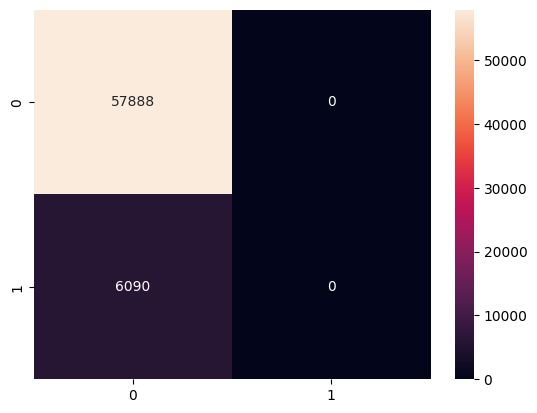

In [96]:
# applying ADABoost on data train_tfidf and test_tfidf using toxic column and logestic regression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
accuracies = []
clf = AdaBoostClassifier(MultinomialNB())
clf.fit(train_tfidf, train['toxic'])
y_pred = clf.predict(test_tfidf)
print(classification_report(test['toxic'], y_pred))
accuracies.append(accuracy_score(test['toxic'], y_pred))
print(accuracies[-1])
# plotting the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test['toxic'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [97]:
# do oversampling of label 1 in toxic column
samples = [1000,5000,10000,20000,40000,70000]
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = train[train.toxic==0]
df_minority = train[train.toxic==1]

# Upsample minority class
data = []

for i in samples:
    df_minority_upsampled = resample(df_minority,
                                        replace=True,     # sample with replacement
                                        n_samples=i,    # to match majority class
                                        random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    data.append(df_upsampled)
    # Display new class counts
    df_upsampled.toxic.value_counts()

# <font color = 'skyblue'>DIFFERENT TYPES OF SAMPLING UNDER , MEDIUM AND OVER SAMPLING AND ANALYSING SOME COOL RESULTS

# Assumption :
As we know that the data is mostly fulled of the clean comments. So, it is assumed that on increasing toxic comments the recall for the class of toxic comments is going to increase It willbe classifying better toxic comments but precision will decrease it will be labelling the clean comments also as TOXIC comments.

In [98]:
data[0]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target
0,explanation edits made username hardcore metal...,0,0,0,0,0,0,0
1,aww match background colour seemingly stuck th...,0,0,0,0,0,0,0
2,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,0
3,make real suggestion improvement wondered sect...,0,0,0,0,0,0,0
4,sir hero chance remember page,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
53488,really fuck paradise edition first added btd p...,1,0,1,0,0,0,1
34118,niggard please niggardly nigger niggerly nigge...,1,0,1,1,1,1,1
49103,pic r internet asshole,1,0,1,0,1,0,1
35340,user child whore,1,0,1,0,1,0,1


In [99]:
train_up = []
test_up = []
for i in data:
# Fit and transform the text data
    tfidf_upsampled = TfidfVectorizer()
    df_upsampled = i
    train_tfidf_upsampled = tfidf_upsampled.fit_transform(df_upsampled['comment_text'])
    train_up.append(train_tfidf_upsampled)
    test_tfidf_upsampled= tfidf_upsampled.transform(test['comment_text'])
    test_up.append(test_tfidf_upsampled)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     57888
           1       0.92      0.21      0.34      6090

    accuracy                           0.92     63978
   macro avg       0.92      0.60      0.65     63978
weighted avg       0.92      0.92      0.90     63978

0.9228015880458907


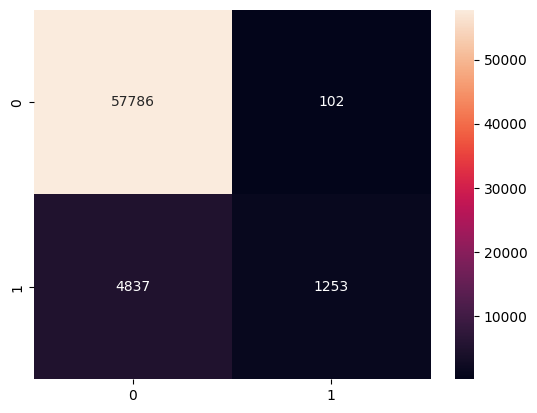

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     57888
           1       0.81      0.48      0.61      6090

    accuracy                           0.94     63978
   macro avg       0.88      0.74      0.79     63978
weighted avg       0.93      0.94      0.93     63978

0.9398543249241927


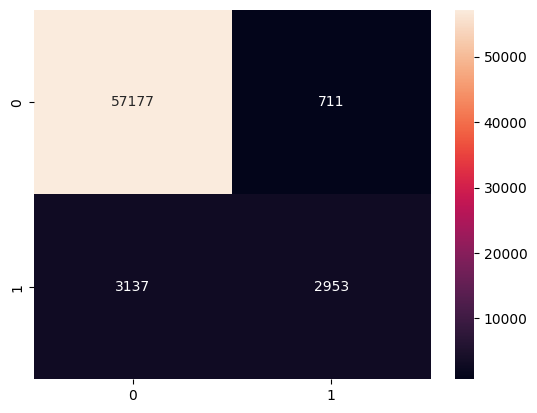

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     57888
           1       0.72      0.61      0.66      6090

    accuracy                           0.94     63978
   macro avg       0.84      0.79      0.82     63978
weighted avg       0.94      0.94      0.94     63978

0.9409015599112195


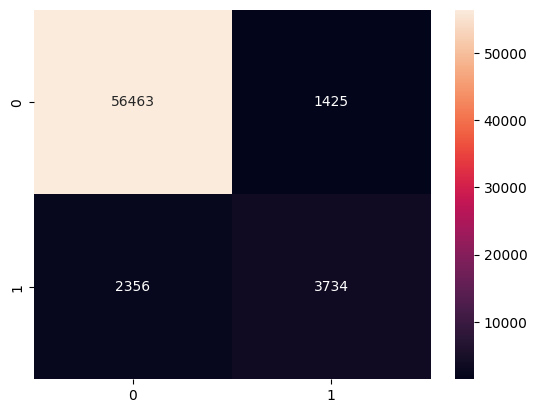

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     57888
           1       0.63      0.73      0.68      6090

    accuracy                           0.93     63978
   macro avg       0.80      0.84      0.82     63978
weighted avg       0.94      0.93      0.94     63978

0.933930413579668


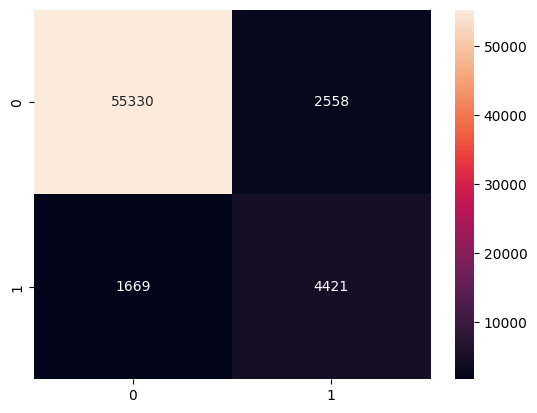

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     57888
           1       0.55      0.81      0.66      6090

    accuracy                           0.92     63978
   macro avg       0.77      0.87      0.81     63978
weighted avg       0.94      0.92      0.93     63978

0.9197067742036324


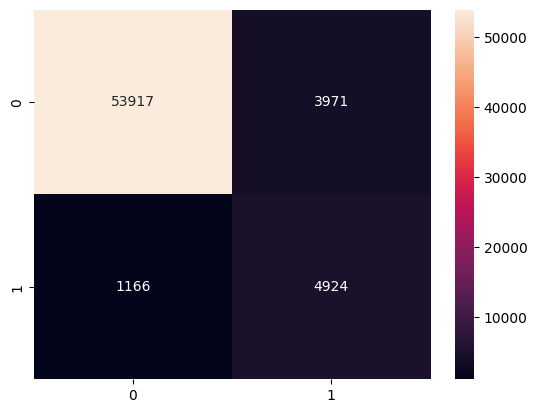

              precision    recall  f1-score   support

           0       0.98      0.91      0.94     57888
           1       0.50      0.86      0.63      6090

    accuracy                           0.90     63978
   macro avg       0.74      0.88      0.79     63978
weighted avg       0.94      0.90      0.91     63978

0.9035918597017725


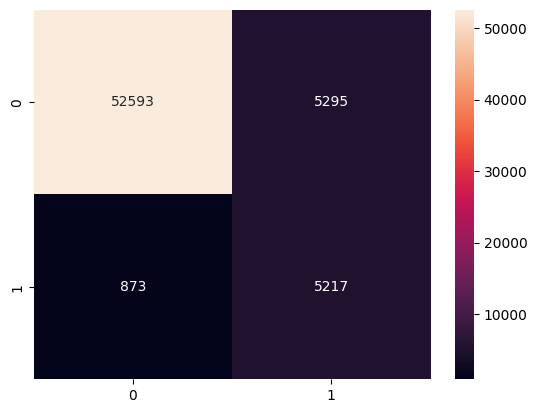

In [100]:
# training the logistic regression model on the train data
acc_up = []
for i in range(len(train_up)):
    df_upsampled = data[i]
    train_tfidf_upsampled = train_up[i]
    test_tfidf_upsampled = test_up[i]
    clf_log_toxic_upsampled = LogisticRegression()
    clf_log_toxic_upsampled.fit(train_tfidf_upsampled, df_upsampled['toxic'])

    # predicting the values for the test data
    y_pred = clf_log_toxic_upsampled.predict(test_tfidf_upsampled)
    print(classification_report(test['toxic'], y_pred))
    acc_up.append(accuracy_score(test['toxic'], y_pred))
    print(accuracy_score(test['toxic'], y_pred))
    # plotting the confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(test['toxic'], y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

As we have noticed that as we increase the sampling of the toxic comments the recall for the class Toxic increases significantly.
But , the accuracies increase upto a middle value then it starts overfitting the model on Toxic Comments and overall acuuracies starts to decrease. 
And also precision also decreases for the class Toxic

# <font color = 'skyblue'> TRAINING THE DECISION TREE OVER THE LOGISTIC REGRESSION 

Assumption : As we have analyzed in abover corelation Graph also that the Toxic column output have significant correlation with other label columns. So, on training the dataset over trained dataset with logistic regression should lead to better output.

In [101]:
train['toxic_log'] = clf_log_toxic.predict(train_tfidf) 
train['severe_toxic_log'] = clf_log_severe_toxic.predict(train_tfidf)
train['insult_log'] = clf_log_insult.predict(train_tfidf)
train['obscene_log'] = clf_log_obscene.predict(train_tfidf)
train['identity_hate_log'] = clf_log_identity_hate.predict(train_tfidf)
train['threat_log'] = clf_log_threat.predict(train_tfidf)
test['toxic_log'] = clf_log_toxic.predict(test_tfidf)
test['severe_toxic_log'] = clf_log_severe_toxic.predict(test_tfidf)
test['insult_log'] = clf_log_insult.predict(test_tfidf)
test['obscene_log'] = clf_log_obscene.predict(test_tfidf)
test['identity_hate_log'] = clf_log_identity_hate.predict(test_tfidf)
test['threat_log'] = clf_log_threat.predict(test_tfidf)
test

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target,toxic_log,severe_toxic_log,insult_log,obscene_log,identity_hate_log,threat_log
5,thank understanding think highly would revert ...,0,0,0,0,0,0,0,0,0,0,0,0,0
7,dear god site horrible,0,0,0,0,0,0,0,1,0,0,0,0,0
11,somebody invariably try add religion really me...,0,0,0,0,0,0,0,0,0,0,0,0,0
13,say right type type institution needed case th...,0,0,0,0,0,0,0,0,0,0,0,0,0
14,adding new product list make sure relevant add...,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153150,jerome see never got around surprised looked e...,0,0,0,0,0,0,0,0,0,0,0,0,0
153151,lucky bastard http wikimediafoundation org wik...,0,0,0,0,0,0,0,0,0,0,0,0,0
153154,shame want speak gay romanian,0,0,0,0,0,0,0,1,0,0,0,0,0
153155,mel gibson nazi bitch make shitty movie ha muc...,1,0,1,0,1,0,1,1,0,1,1,0,0


In [102]:
test[['severe_toxic_log'	,'obscene_log',	'threat_log'	,'insult_log',	'identity_hate_log'	,'toxic_log']].to_numpy()

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0]])

In [103]:
train[['severe_toxic_log'	,'obscene_log',	'threat_log'	,'insult_log',	'identity_hate_log'	,'toxic_log']].to_numpy()

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

<Axes: >

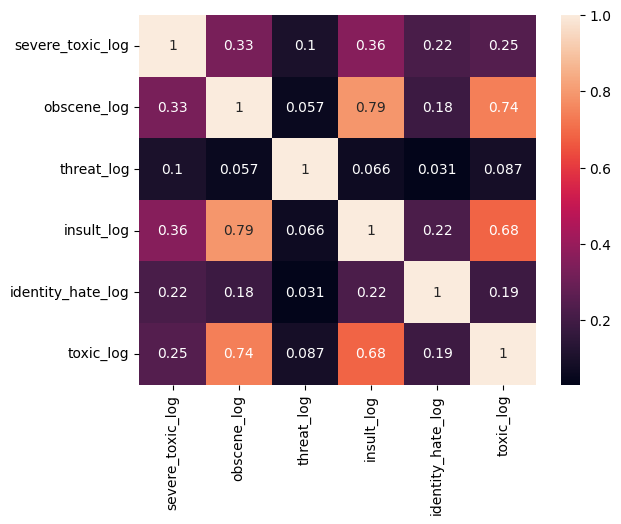

In [104]:
# seperating X and y as toxic column as y and other labels as X
X_train = train[['severe_toxic_log'	,'obscene_log',	'threat_log'	,'insult_log',	'identity_hate_log']].to_numpy()

y_train = train['toxic_log'].to_numpy()

X_test = test[['severe_toxic_log'	,'obscene_log',	'threat_log'	,'insult_log',	'identity_hate_log']].to_numpy()

y_test = test['toxic'].to_numpy()
sns.heatmap(train[['severe_toxic_log'	,'obscene_log',	'threat_log'	,'insult_log',	'identity_hate_log','toxic_log']].corr(), annot=True)

In [105]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
print(accuracy_score(y_test,dtc.predict(X_test)))

0.9404639094688799


In [106]:
pickle_out=open("dtc_toxic.pkl","wb")
pickle.dump(dtc,pickle_out)
pickle_out.close()

In [107]:
log = LogisticRegression()
log.fit(X_train,y_train)
print(accuracy_score(y_test,log.predict(X_test)))

0.9404639094688799


In [108]:
from sklearn.ensemble import GradientBoostingClassifier
nb = GradientBoostingClassifier()
nb.fit(X_train,y_train)
print(accuracy_score(y_test,nb.predict(X_test)))

0.9404639094688799


Result : As we have 

# <font color = 'skyblue'>APPLYING DEEP LEANING BASED VECTORIZER FOR CONVERTING WORDS TO VECTORS : WORD EMBEDDING

# <font color = 'skyblue'>APPLYING WORD2VEC ON THE DATA

In [4]:
train_word2vec = pd.read_csv('/content/drive/MyDrive/PRML_MAJOR/train_cleaned.csv')
test_word2vec = pd.read_csv('/content/drive/MyDrive/PRML_MAJOR/test_cleaned.csv')

In [5]:
train = train_word2vec
test = test_word2vec

In [6]:
#vectorize word2vec
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# tokenize the words
train['tokenized'] = train['comment_text'].apply(word_tokenize)
test['tokenized'] = test['comment_text'].apply(word_tokenize)

# remove stop words
train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stop_words])
test['tokenized'] = test['tokenized'].apply(lambda x: [item for item in x if item not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
train['tokenized']

0         [[, 'explanation, ', ,, 'edits, ', ,, 'made, '...
1         [[, 'aww, ', ,, 'match, ', ,, 'background, ', ...
2         [[, 'hey, ', ,, 'man, ', ,, 'really, ', ,, 'tr...
3         [[, 'make, ', ,, 'real, ', ,, 'suggestion, ', ...
4         [[, 'sir, ', ,, 'hero, ', ,, 'chance, ', ,, 'r...
                                ...                        
159566    [[, 'second, ', ,, 'time, ', ,, 'asking, ', ,,...
159567    [[, 'ashamed, ', ,, 'horrible, ', ,, 'thing, '...
159568    [[, 'spitzer, ', ,, 'umm, ', ,, 'actual, ', ,,...
159569    [[, 'look, ', ,, 'like, ', ,, 'wa, ', ,, 'actu...
159570    [[, 'really, ', ,, 'think, ', ,, 'understand, ...
Name: tokenized, Length: 159571, dtype: object

In [8]:
#word2vec
model = Word2Vec(train['tokenized'], min_count=1, window=10, workers=4,vector_size=1000)

In [9]:
# get the word vectors
word_vectors = model.wv
print(word_vectors)

KeyedVectors<vector_size=1000, 180663 keys>


In [10]:
#get vectorised data
def get_vectorized_data(data):
    vectorised_tokens = []
    for token in data:
        if token in word_vectors:
            vectorised_tokens.append(word_vectors[token])

    if len(vectorised_tokens) == 0:
        return np.zeros(100)
    return word_vectors.get_mean_vector(vectorised_tokens)

In [11]:
import pickle
pickle_out=open("Word2Vec.pkl","wb")
pickle.dump(model,pickle_out)
pickle_out.close()

In [12]:
#vectorize the data
X_train = np.array([get_vectorized_data(data) for data in train['tokenized']])
X_test = np.array([get_vectorized_data(data) for data in test['tokenized']])

In [13]:
y_train=train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
y_test=test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [14]:
#using logistic regression classifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#train the model
lr = LogisticRegression()
lr.fit(X_train, y_train['toxic'])

#predict the model
y_pred = lr.predict(X_test)

#check the accuracy

print("Accuracy:",accuracy_score(y_test['toxic'], y_pred))

#check the classification report
print(classification_report(y_test['toxic'], y_pred))

Accuracy: 0.9303979492950701
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     57888
           1       0.64      0.61      0.63      6090

    accuracy                           0.93     63978
   macro avg       0.80      0.79      0.79     63978
weighted avg       0.93      0.93      0.93     63978



In [15]:
X_test

array([[-5.4228801e-01, -5.1188882e-02, -4.0972999e-01, ...,
        -1.3658230e-01,  6.3231498e-02, -3.3216217e-01],
       [-4.4491866e-01,  9.2837222e-02, -4.1704938e-01, ...,
         2.3014426e-02, -9.5545724e-02, -5.4200524e-01],
       [-5.3176528e-01, -5.2474523e-03, -4.2910376e-01, ...,
        -1.4543688e-01,  6.8806328e-02, -4.5246914e-01],
       ...,
       [-4.9510920e-01,  1.3739404e-01, -3.7543288e-01, ...,
        -8.9469329e-03,  2.6774095e-02, -5.0266820e-01],
       [-4.6394750e-01, -1.6114445e-02, -4.4882163e-01, ...,
        -1.6790712e-01, -1.0010848e-02, -4.9364454e-01],
       [-4.6412405e-01, -1.6669184e-04, -4.2021412e-01, ...,
        -1.8360049e-01,  1.1915255e-02, -4.5391119e-01]], dtype=float32)

In [16]:

pickle_out=open("lr_word2vec_toxic.pkl","wb")
pickle.dump(lr,pickle_out)
pickle_out.close()

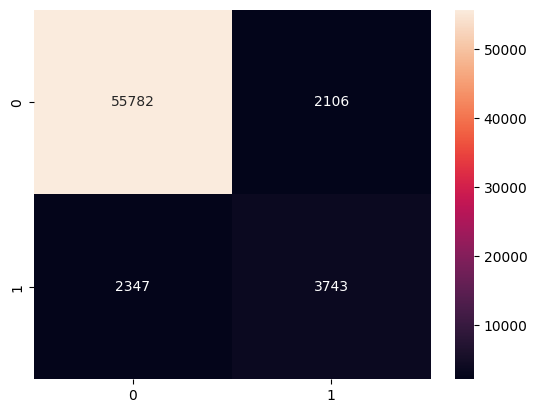

In [17]:
#plot confusion matrix on y_test and y_pred
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test['toxic'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [18]:
lr = LogisticRegression()
lr.fit(X_train, y_train['obscene'])

#predict the model
y_pred = lr.predict(X_test)

#check the accuracy

print("Accuracy:",accuracy_score(y_test['obscene'], y_pred))

#check the classification report
print(classification_report(y_test['obscene'], y_pred))

Accuracy: 0.9614867610741192
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     60287
           1       0.71      0.57      0.63      3691

    accuracy                           0.96     63978
   macro avg       0.84      0.78      0.80     63978
weighted avg       0.96      0.96      0.96     63978



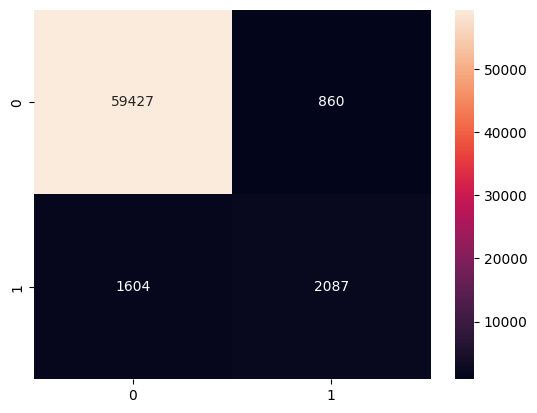

In [19]:
cm = confusion_matrix(y_test['obscene'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [20]:
lr = LogisticRegression()
lr.fit(X_train, y_train['severe_toxic'])

#predict the model
y_pred = lr.predict(X_test)

#check the accuracy

print("Accuracy:",accuracy_score(y_test['severe_toxic'], y_pred))

#check the classification report
print(classification_report(y_test['severe_toxic'], y_pred))

Accuracy: 0.9924505298696427
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63611
           1       0.33      0.31      0.32       367

    accuracy                           0.99     63978
   macro avg       0.66      0.65      0.66     63978
weighted avg       0.99      0.99      0.99     63978



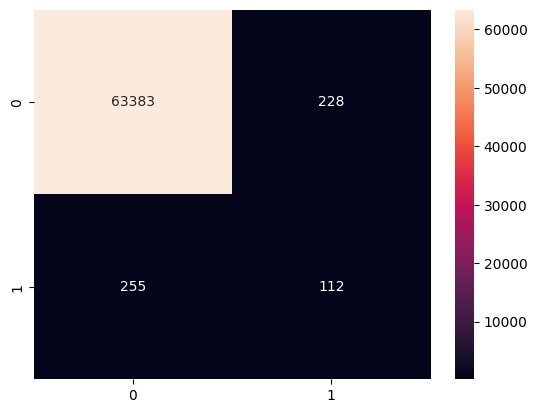

In [21]:
cm = confusion_matrix(y_test['severe_toxic'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [22]:
lr = LogisticRegression()
lr.fit(X_train, y_train['threat'])

#predict the model
y_pred = lr.predict(X_test)

#check the accuracy

print("Accuracy:",accuracy_score(y_test['threat'], y_pred))

#check the classification report
print(classification_report(y_test['threat'], y_pred))

Accuracy: 0.9964987964612836
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63767
           1       0.44      0.22      0.29       211

    accuracy                           1.00     63978
   macro avg       0.72      0.61      0.64     63978
weighted avg       1.00      1.00      1.00     63978



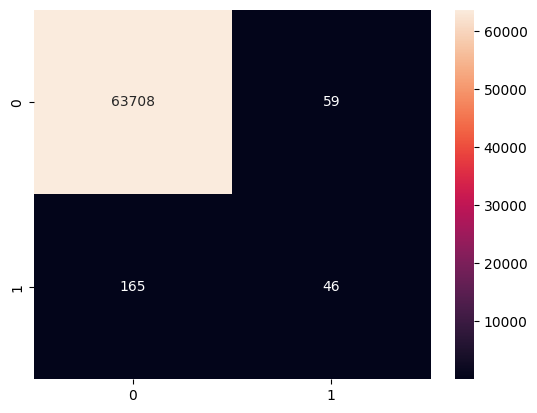

In [23]:
cm = confusion_matrix(y_test['threat'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [24]:
lr = LogisticRegression()
lr.fit(X_train, y_train['insult'])

#predict the model
y_pred = lr.predict(X_test)

#check the accuracy

print("Accuracy:",accuracy_score(y_test['insult'], y_pred))

#check the classification report
print(classification_report(y_test['insult'], y_pred))

Accuracy: 0.9595173340835912
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     60551
           1       0.68      0.46      0.55      3427

    accuracy                           0.96     63978
   macro avg       0.83      0.72      0.76     63978
weighted avg       0.95      0.96      0.96     63978



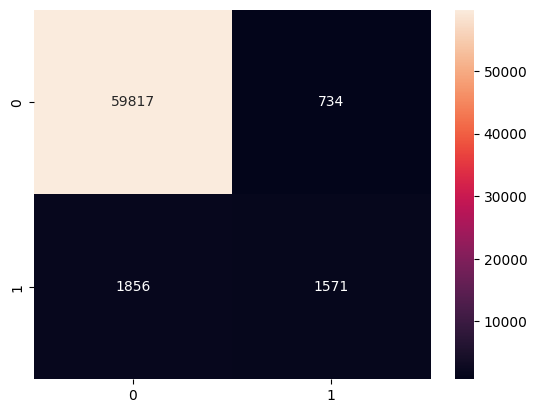

In [25]:
cm = confusion_matrix(y_test['insult'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [26]:
lr = LogisticRegression()
lr.fit(X_train, y_train['identity_hate'])

#predict the model
y_pred = lr.predict(X_test)

#check the accuracy

print("Accuracy:",accuracy_score(y_test['identity_hate'], y_pred))

#check the classification report
print(classification_report(y_test['identity_hate'], y_pred))

Accuracy: 0.9883084810403576
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     63266
           1       0.43      0.17      0.24       712

    accuracy                           0.99     63978
   macro avg       0.71      0.58      0.62     63978
weighted avg       0.98      0.99      0.99     63978



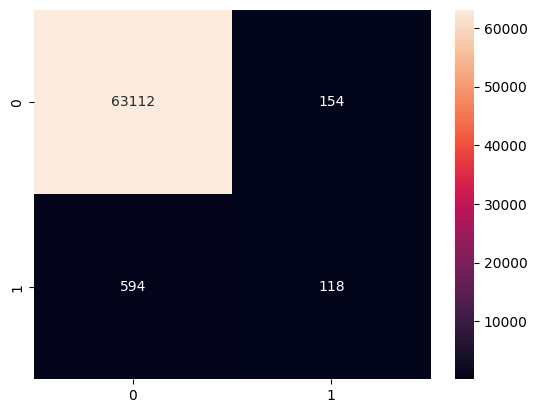

In [27]:
cm = confusion_matrix(y_test['identity_hate'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

#<font color = 'skyblue'> USING GOOGLE NEWS MODEL

In [28]:
 # load google news word2vec model
from gensim.models import KeyedVectors
filename = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz'
news_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [29]:
# getting vectorised data
def vectorize_data(data,model):
    vectors = []
    for i in data:
        vector = np.zeros(300)
        count = 0
        for word in i:
            try:
                vector += model.wv[word]
                count += 1
            except:
                pass
        vector /= count
        vectors.append(vector)
    return vectors

In [30]:
x_train_news= vectorize_data(train_word2vec['comment_text'],news_model)
X_test_news= vectorize_data(test_word2vec['comment_text'],news_model)

In [31]:
y_train_news=train_word2vec[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
y_test_news=test_word2vec[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [32]:
# handle nan values x_train_vectorised and x_test_vectorised 
x_train_news = np.nan_to_num(x_train_news)
x_test_news = np.nan_to_num(X_test_news)

In [33]:
#using logistic regression classifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#train the model
lr_toxic_news = LogisticRegression()
lr_toxic_news.fit(x_train_news, y_train_news['toxic'])

#predict the model
y_pred = lr_toxic_news.predict(x_test_news)

#check the accuracy

print("Accuracy:",accuracy_score(y_test_news['toxic'], y_pred))

#check the classification report
print(classification_report(y_test_news['toxic'], y_pred))

Accuracy: 0.9048110287911469
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     57888
           1       0.00      0.00      0.00      6090

    accuracy                           0.90     63978
   macro avg       0.45      0.50      0.48     63978
weighted avg       0.82      0.90      0.86     63978



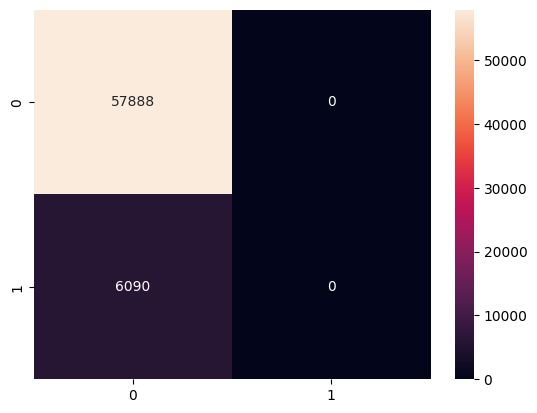

In [34]:
#plot confusion matrix on y_test and y_pred
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_news['toxic'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [35]:
#train the model
lr_insult_news = LogisticRegression()
lr_insult_news.fit(x_train_news, y_train_news['insult'])

#predict the model
y_pred = lr_insult_news.predict(x_test_news)

#check the accuracy

print("Accuracy:",accuracy_score(y_test_news['insult'], y_pred))

#check the classification report
print(classification_report(y_test_news['insult'], y_pred))

Accuracy: 0.9464347119322267
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     60551
           1       0.00      0.00      0.00      3427

    accuracy                           0.95     63978
   macro avg       0.47      0.50      0.49     63978
weighted avg       0.90      0.95      0.92     63978



Since this model is not performing well so there is no need to go on for further testing.